# DATA522 Final Exploration

## Library choice

* **PyArrow**: The dataset we were using was only available in the Parquet format
* **OCRMac**: We found that EasyOCR, while cross-platform, performed much worse than the built-in Apple OCR model, for which OCRMac provides a wrapper. We did use EasyOCR for our student-contributed lecture, but if we were to generate our dataset with EasyOCR, it would still be running today.
* **Transformers**: Transformers is used to download and run the `distilbert` sentiment analysis model.

In [ ]:
# Install libraries for reading in Parquet and OCR
%pip install pyarrow
# If you run this on windows your computer will explode :-)
%pip install ocrmac
# %pip install pytesseract
# %pip install easyocr

# Pre-trained sentiment analysis model
%pip install transformers

# CV2 (required for image operations)
%pip install opencv-python

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import easyocr
from ocrmac import ocrmac
import cv2
import PIL
# necessary for distilbert pipeline
from transformers import pipeline

In [2]:
# Get all data Parquets
def read_dataset(dirname):
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    return [
        pd.
            read_parquet(
                f'{dirname}/{filename}'
            )
            .drop(columns = ['caption']) 
        for filename in training_filenames
    ]

In [159]:
# load the easyOCR library -- removed because we decided to use OCRMac instead
# state_easyocr = {
#     "reader": easyocr.Reader(['en'])
# }

# load the distilbert pipeline
state_sentiment = {
    "pipeline": pipeline("sentiment-analysis")
}

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [160]:
# stolen from https://stackoverflow.com/questions/17170752/python-opencv-load-image-from-byte-string
# (shamelessly)
def bytes2cv2(image):
    # images are stored as bytes, which we will cast into 8-bit ints
    img_bytes = image['bytes']
    return cv2.imdecode(
        np.frombuffer(
            img_bytes, 
            np.uint8
        ),
        # the glory of color
        cv2.IMREAD_COLOR_RGB
    )

# show a given image from the original dataset
def imshow(image):
    decoded_image = bytes2cv2(image)
    plt.imshow(decoded_image)

# use the distilbert model to get the sentiment of an image (between -1 and 1, depending on the confidence)
def analyze_sentiment(text, state_sentiment):
    sentiment = state_sentiment["pipeline"](text)[0]
    if sentiment["label"] == "NEGATIVE":
        return -1 * sentiment["score"]
    elif sentiment["label"] == "NEUTRAL":
        return 0
    return sentiment["score"]

# def easyocr_filtertext(read_text):
#     return ' '.join(read_text).upper()
    
# def ocr_easyocr(image, state):
#     decoded_image = bytes2cv2(image)
#     return easyocr_filtertext(state['reader'].readtext(decoded_image, detail = 0))

# use OCRMac to read text from an image
def ocr_ocrmac(image):
    pil_image = PIL.Image.fromarray(
        bytes2cv2(image)
    )
    ocr_result = ocrmac.text_from_image(
        pil_image
    )
    # Get just the text from the images
    return ' '.join(
        [
            ocr_tuple[0] 
            for ocr_tuple 
            in ocr_result
        ]
    )


def ocr_and_text_sentiment_row(row):
    text_ocrmac = ocr_ocrmac(row.image)
    sentiment_ocrmac = analyze_sentiment(text_ocrmac, state_sentiment)
    return pd.Series(
        {
            "text_ocrmac": text_ocrmac,
            "sentiment_ocrmac": sentiment_ocrmac
        }
    )

# Create pared-down dataset
def ocr_and_text_sentiment(df):
    df_ocr = pd.concat([df, df.apply(
        ocr_and_text_sentiment_row,
        axis = 1,
        # Expand the series into new columns
        result_type = 'expand'
    )], axis = 1)
    return df_ocr

# This function takes an extremely long time to run
# Run at your own peril
def create_pared_dataset(dirname):
    training_parquets = read_dataset(dirname)
    
    for i, training_parquet in enumerate(training_parquets):
        # Do not save image data, that would be insane
        (
            ocr_and_text_sentiment(training_parquet)
            # The pared dataset will not contain the original images but will contain both
            # OCR results and sentiment analysis scores
                .drop(columns = 'image')
                .to_parquet(f'{dirname}/parquet_{i}-sentiment.parquet')
        )
def read_pared_dataset(dirname):
    sentiment_filenames = sorted([
        filename for filename in os.listdir(dirname) if filename.endswith('.parquet') and not filename.startswith('train')
    ])
    training_filenames = sorted([
        filename 
        for filename in os.listdir(dirname) 
        if filename.endswith('.parquet') and filename.startswith('train') 
    ])
    sentiment_parquets = [
        pd.read_parquet(f'{dirname}/{filename}').assign(filename = f'{dirname}/{training_filenames[idx]}') 
        for idx, filename in enumerate(sentiment_filenames)
    ]
    return pd.concat(sentiment_parquets).reset_index().rename(columns = {'index': 'row_within_file'})

# Get an image from the original dataset given a row from the pared-down dataset
def get_image(row):
    filename = row.filename
    row_within_file = row.row_within_file
    imshow(pd.read_parquet(filename).image.loc[row_within_file])

## graph time
##### graph time

In [148]:
sentiment_dataset

,row_within_file,panel_name,characters,themes,color,year,text_ocrmac,sentiment_ocrmac,filename
0,0,19501002_00,"[Charlie Brown, Patty, Shermy]",[],grayscale,1950,HOW I HATE HIM ! SCHULZ,-0.998045,./data/train-00000-of-00006-2c5eee001709386a.p...
1,1,19501002_01,"[Charlie Brown, Patty, Shermy]",[],grayscale,1950,GOOD OL' CHARLIE BROWN...,0.999833,./data/train-00000-of-00006-2c5eee001709386a.p...
2,2,19501002_02,"[Charlie Brown, Patty, Shermy]",[],grayscale,1950,"GOOD OL' CHARLIE BROWN ...YES, SIR!",0.999836,./data/train-00000-of-00006-2c5eee001709386a.p...
3,3,19501002_03,"[Charlie Brown, Patty, Shermy]",[],grayscale,1950,WELL! HERE COMES OL' CHARLIE BROWN!,0.998995,./data/train-00000-of-00006-2c5eee001709386a.p...
4,4,19501003_00,"[Charlie Brown, Patty]",[],grayscale,1950,THAT'S WHAT LITTLE GIRLS ARE MADE OF !,0.999516,./data/train-00000-of-00006-2c5eee001709386a.p...
...,...,...,...,...,...,...,...,...,...
77451,12904,20000206_05,"[Charlie Brown, Sally Brown]","[love, rain]",color,2000,,0.748121,./data/train-00005-of-00006-5284710f85c75630.p...
77452,12905,20000206_06,"[Charlie Brown, Sally Brown]","[love, rain]",color,2000,THE INSIDE OF A MAILBOX SHOULD ALWAYS BE KEPT ...,-0.997853,./data/train-00005-of-00006-5284710f85c75630.p...
77453,12906,20000206_07,"[Charlie Brown, Sally Brown]","[love, rain]",color,2000,,0.748121,./data/train-00005-of-00006-5284710f85c75630.p...
77454,12907,20000206_08,"[Charlie Brown, Sally Brown]","[love, rain]",color,2000,,0.748121,./data/train-00005-of-00006-5284710f85c75630.p...


TypeError: only length-1 arrays can be converted to Python scalars

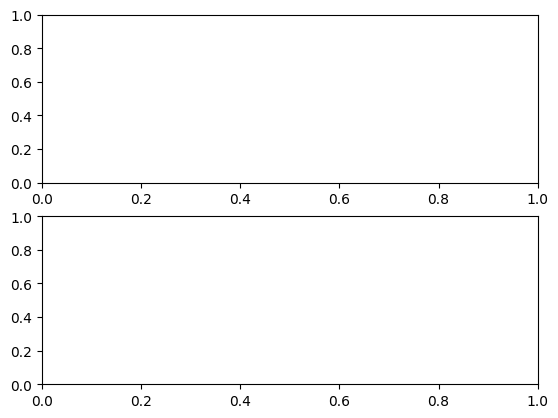

In [158]:
sentiment_dataset_n_characters = sentiment_dataset.assign(
    n_characters = sentiment_dataset.characters.apply(lambda characters: len(characters)),
    positive_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac > 0), 
    negative_sentiment = np.int64(sentiment_dataset.sentiment_ocrmac < 0)
)

plots_0_data = (
    sentiment_dataset_n_characters
        .select_dtypes(exclude = ['object'])
        .groupby('year').agg(
            {'positive_sentiment': 'sum',
            'negative_sentiment': 'sum',
            'n_characters': 'mean'}
        )
)

fig, ax = plt.subplots(2, 1)

ax[0].bar(plots_0_data.index, plots_0_data.positive_sentiment, color = 'blue')
ax[0].bar(plots_0_data.index, -1 * plots_0_data.negative_sentiment, color = 'red')

plt.show()